# Mushrooms classification - Keras

This notebook is used to build and train a binary classification neural network. We will train it for the [Kaggle - Mushroom Classification](https://www.kaggle.com/uciml/mushroom-classification) project. The data should be already processed and saved to .npy files. See the `mushrooms_data_preparation.ipynb` notebook from this repository to process the data.

### Import used modules

The only external modules used for this notebook are [numpy](http://www.numpy.org/), [tensorflow](https://www.tensorflow.org/), and [matplotlib](https://matplotlib.org/).

In [1]:
%matplotlib inline

import sys
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Load the processed data

First we need to load the processed data. This files are loaded as numpy arrays.

In [2]:
training_data = np.load(open("training_data/mushrooms_training_data.npy", 'rb'))
training_labels = np.load(open("training_data/mushrooms_training_labels.npy", 'rb'))
validation_data = np.load(open("training_data/mushrooms_validation_data.npy", 'rb'))
validation_labels = np.load(open("training_data/mushrooms_validation_labels.npy", 'rb'))
test_data = np.load(open("training_data/mushrooms_test_data.npy", 'rb'))
test_labels = np.load(open("training_data/mushrooms_test_labels.npy", 'rb'))

Print data type and arrays shapes.

In [3]:
print("Loaded data type = {}".format(type(training_data)))
print("Training data shape = {}".format(training_data.shape))
print("Training labels shape = {}".format(training_labels.shape))
print("Validation data shape = {}".format(validation_data.shape))
print("Validation labels shape = {}".format(validation_labels.shape))
print("Test data shape = {}".format(test_data.shape))
print("Test labels shape = {}".format(test_labels.shape))

Loaded data type = <class 'numpy.ndarray'>
Training data shape = (6500, 117)
Training labels shape = (6500, 1)
Validation data shape = (812, 117)
Validation labels shape = (812, 1)
Test data shape = (812, 117)
Test labels shape = (812, 1)


## Create model

Now we will define our neural network model. We will create a [Keras](https://www.tensorflow.org/guide/keras) model that we can later train. We need to perform the next operations
- **Inputs**: We need to create keras inputs for the model. We will need only a data input.
- **Hidden layers**: In this model we will use a stack of keras [fully connected layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). The number, size and activation function of this layers can be changed from the model parameters variables.
- **Output layer**: We will use a fully connected layer, with size 1 (one neuron) and a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function (the standart output function for binary classification).
- **Instantiate model**: We create de keras model indicating the input and output of it.
- **Compile model**: We compile the model with the loss function we want to use, the optimizer and the metrics we want to keep trak of.
- **Callbacks**: Utilities called at certain points during model training ([info](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)).

### Model parameters

This parameters are used to easily change the model architecture to try different configurations and find the best for our specific task.

In [4]:
# Parameters
fully_connected_layers = 3
fully_connected_size = 50
fully_connected_activation = "relu"

### Training hyperparameters

These are the hyperparameters we need to tune in order to get the model and training to work. Try different values to see how the training and model performance change.

In [5]:
# Hyperparameters
epochs = 50
batch_size = 128
learning_rate = 0.01

### Create model inputs

We first create the model inputs. This are later used to feed data to the model. We need only a data input for this model.

In [6]:
tf.reset_default_graph()

In [7]:
# Data input
x = tf.keras.Input(shape=(training_data.shape[1], ), name="inputs")
print(x)

Tensor("inputs:0", shape=(?, 117), dtype=float32)


### Create hidden layers

In [8]:
dense_layers = fully_connected_layers

# Create first dense layer
# Shape: (batch_size, fully_connected_size)
dense = tf.keras.layers.Dense(fully_connected_size,
                              activation=fully_connected_activation,
                              name="dense_1")(x)

print(dense)

dense_layers -= 1
dense_layer_count = 2

# Create next dense layers
for i in range(dense_layers):
    # Shape: (batch_size, fully_connected_size)
    dense = tf.keras.layers.Dense(fully_connected_size,
                                  activation=fully_connected_activation,
                                  name="dense_{}".format(dense_layer_count))(dense)
    
    print(dense)
    
    dense_layer_count += 1

Tensor("dense_1/Relu:0", shape=(?, 50), dtype=float32)
Tensor("dense_2/Relu:0", shape=(?, 50), dtype=float32)
Tensor("dense_3/Relu:0", shape=(?, 50), dtype=float32)


### Create output layer

In [9]:
# Shape: (batch_size, 1)
output_layer = tf.keras.layers.Dense(1,
                                     activation="sigmoid",
                                     name="output_layer")(dense)

print(output_layer)

Tensor("output_layer/Sigmoid:0", shape=(?, 1), dtype=float32)


### Instantiate the model

In [10]:
model = tf.keras.Model(inputs=x, outputs=output_layer)

### Compile the model

In [11]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=learning_rate),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 117)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5900      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


### Create callbacks

In [12]:
# Create callbacks
callbacks = []

# Model checkpoint (save model)
model_dir = Path(Path.cwd(), "trained_models", "keras")
model_dir.mkdir(exist_ok=True, parents=True)
model_file = "./trained_models/keras/model.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor='val_acc', save_best_only=True)
callbacks.append(model_checkpoint)

# File with training history (.csv)
csv_logger = tf.keras.callbacks.CSVLogger(str(model_dir) + "/training_history.csv")
callbacks.append(csv_logger)

# Tensorboard
tensorboard_logs_dir = Path(Path.cwd(), "tensorboard_logs")
tensorboard_logs_dir.mkdir(exist_ok=True)
tensorboard_job_name = "keras_dl_{}-ds_{}-lr_{}-e_{}-b_{}".format(fully_connected_layers,
                                                                  fully_connected_size,
                                                                  learning_rate,
                                                                  epochs,
                                                                  batch_size)
tensorboard_log_dir = Path(tensorboard_logs_dir, tensorboard_job_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=str(tensorboard_log_dir),
                                                      histogram_freq=1,
                                                      write_graph=False,
                                                      write_grads=True,
                                                      write_images=True,
                                                      batch_size=batch_size)
callbacks.append(tensorboard_callback)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_acc",
                                                  patience=10)
callbacks.append(early_stopping)

### Tensorboard model graph

The [tf.keras.callbacks.TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) has an argument to save the model graph to Tensorboard, but keras adds a lot of different operations that really mess with the model architecture information, so we will save the model graph using tensorflow.

In [13]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter(str(tensorboard_log_dir))
    writer.add_graph(sess.graph)

## Model training

In [14]:
history = model.fit(training_data, training_labels,
                    epochs=epochs,
                    validation_data=(validation_data, validation_labels),
                    verbose=2,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    shuffle=True)

Train on 6500 samples, validate on 812 samples
Epoch 1/50
 - 0s - loss: 0.6691 - acc: 0.6665 - val_loss: 0.6408 - val_acc: 0.8411
Epoch 2/50
 - 0s - loss: 0.5895 - acc: 0.8611 - val_loss: 0.5741 - val_acc: 0.9384
Epoch 3/50
 - 0s - loss: 0.4961 - acc: 0.8791 - val_loss: 0.4715 - val_acc: 0.9594
Epoch 4/50
 - 0s - loss: 0.3976 - acc: 0.8891 - val_loss: 0.3511 - val_acc: 0.9606
Epoch 5/50
 - 0s - loss: 0.3155 - acc: 0.8940 - val_loss: 0.2605 - val_acc: 0.9631
Epoch 6/50
 - 0s - loss: 0.2537 - acc: 0.9048 - val_loss: 0.2004 - val_acc: 0.9594
Epoch 7/50
 - 0s - loss: 0.2052 - acc: 0.9203 - val_loss: 0.1636 - val_acc: 0.9581
Epoch 8/50
 - 0s - loss: 0.1660 - acc: 0.9457 - val_loss: 0.1405 - val_acc: 0.9594
Epoch 9/50
 - 0s - loss: 0.1348 - acc: 0.9652 - val_loss: 0.1256 - val_acc: 0.9631
Epoch 10/50
 - 0s - loss: 0.1109 - acc: 0.9754 - val_loss: 0.1164 - val_acc: 0.9655
Epoch 11/50
 - 0s - loss: 0.0925 - acc: 0.9802 - val_loss: 0.1104 - val_acc: 0.9692
Epoch 12/50
 - 0s - loss: 0.0784 - acc

## Plot cost and accuracy during training

Now we plot the how the cost and accuracy change during training, for both the training data and the validation data. This information is also ploted in Tensorboard, but we plot it here anyways.

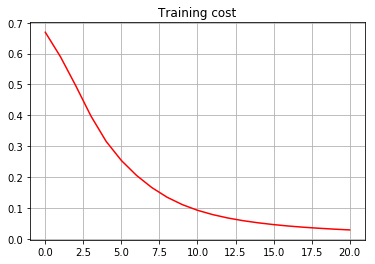

In [18]:
plt.plot(range(len(history.history["loss"])), history.history["loss"], color="red")
plt.title("Training cost")
plt.grid()

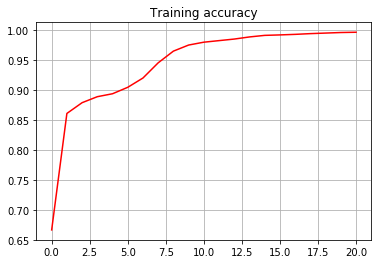

In [19]:
plt.plot(range(len(history.history["acc"])), history.history["acc"], color="red")
plt.title("Training accuracy")
plt.grid()

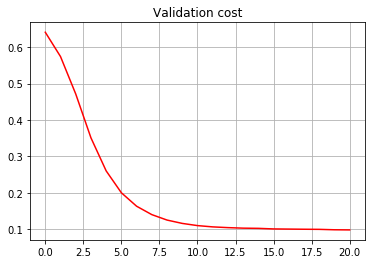

In [20]:
plt.plot(range(len(history.history["val_loss"])), history.history["val_loss"], color="red")
plt.title("Validation cost")
plt.grid()

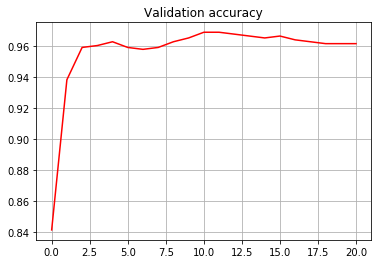

In [21]:
plt.plot(range(len(history.history["val_acc"])), history.history["val_acc"], color="red")
plt.title("Validation accuracy")
plt.grid()

## Test model

We will use the test data we have loaded to test our model performance on unseen data.

In [28]:
test_results = model.evaluate(test_data,
                              test_labels,
                              batch_size=None,
                              verbose=1)

print("Test accuracy = {}".format(test_results[1]))

812/812 [==============================] - 0s 20us/step
Test accuracy = 0.9211822663034711


## Tensorboard

To use tensorboard open a console, go to the project folder (`"mushrooms"`) and type:

```bash
tensorboard --logdir tensoboard_logs\
```

### Tensoboard results

#### Model graph

The model graph shows the model architecture. The arrows represent the tensors flowing and their shape.

![graph](notebook_images/keras_graph.png)

#### Output layer values

We can se the output layer values progress during training in this histogram. The distribution in the back shows the values when we start the training. There the we can see that the model outputs a lot of values near 0.5, but the model quickly learn to output values near 0 and 1. This layer has a sigmoid activation so the output values are always in the range (0, 1).

![output_layer_histograms](notebook_images/keras_output_layer_histograms.png)

#### Train set cost and accuracy

Tensorboard shows us the scalar values we asked for, in this case the training set cost and accuracy.

![training_scalars](notebook_images/keras_training_scalars.png)

#### Validation set cost and accuracy

We also add scalars in Tensorboard for the validation set cost and accuracy.

![validation_scalars](notebook_images/keras_validation_scalars.png)